In [1]:
import os
import time
import dill
from typing import List
from functools import reduce
from calendar import monthrange

In [2]:
import json
import csv
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import urllib.request as urllib2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from random import sample, randint, shuffle
from sklearn.decomposition import PCA

In [4]:
import nltk
import text_summarizer
from gensim.utils import simple_preprocess
from gensim.summarization.summarizer import summarize
from gensim.models import Word2Vec, LsiModel
from gensim.test.utils import common_dictionary, common_corpus

In [5]:
from time import process_time

In [6]:
t = process_time()
dill.load_session('thesis_env.db')
process_time() - t

71.63257700000001

In [7]:
len(adjectives)

393

In [8]:
len(all_)

1685787

## Gender-neutral adjectives describing people

In [9]:
with open('objects.csv') as csv_file:
    objects = csv_file.read().split("\n")
objects[0] = 'angle'

In [89]:
# url = 'https://www.enchantedlearning.com/wordlist/adjectivesforpeople.shtml'
# file = urllib2.urlopen(url)
# html = file.read()
# file.close()
# soup = BeautifulSoup(html)

In [8]:
# adjs = [x.contents[0] for x in BeautifulSoup(html).find_all(attrs={"class": "wordlist-item"})]

In [16]:
# with open('adjectives.csv', mode='w') as f:
#     writer = csv.writer(f, delimiter=',')
#     writer.writerow(adjs)

In [5]:
with open('adjectives.csv') as csv_file:
    adjectives = csv_file.read().split(",")

In [6]:
adjectives[:5]

['able', 'abnormal', 'above average', 'absent-minded', 'adventurous']

In [7]:
dill.dump_session('thesis_env.db')

In [5]:
# url = 'https://www.britannica.com/topic/list-of-cities-and-towns-in-the-United-States-2023068'
# file = urllib2.urlopen(url)
# html = file.read()
# file.close()
# soup = BeautifulSoup(html)  

In [6]:
# alist = soup.find_all(attrs={"class": "md-crosslink"})

In [7]:
# places = [a.contents[0] for a in alist[3:]]

In [8]:
# len(places)

2010

In [9]:
# with open('cities.csv', mode='w') as f:
#     writer = csv.writer(f, delimiter=',')
#     writer.writerow(places)

In [9]:
with open('cities.csv') as csv_file:
    cities = csv_file.read().split(",")

In [10]:
cities[:5]

['Alabama', 'Alexander City', 'Andalusia', 'Anniston', 'Athens']

# Data Parsing and Processing

In [13]:
class Doc:
    def __init__(self, id: int, gdescriptors: List[str], descriptors: List[str], text: str) -> None:
        self.id = id
        self.gdescriptors = gdescriptors
        self.descriptors = descriptors
        self.text = text

In [14]:
def parse_doc(file: str) -> Doc:
    tree = ET.parse(file)
    root = tree.getroot()
    try:
        fulltext = root.find('body').find('body.content').find("*[@class='full_text']")
        text = reduce(lambda x, y: x + y, [x.text for x in fulltext.findall('p')])
        id = int(root.find('head').find('docdata').find('doc-id').attrib['id-string'])
        classifiers = root.find('head').find('docdata').find('identified-content')
        gclassifiers = classifiers.findall("*[@class='online_producer'][@type='general_descriptor']")
        dclassifiers = classifiers.findall("*[@class='online_producer'][@type='descriptor']")
        gdescriptors = [c.text for c in gclassifiers]
        descriptors = [c.text for c in dclassifiers]
        return Doc(id, gdescriptors, descriptors, text)
    except:
        return None

In [15]:
def get_docs_by_month(year: int, month: int) -> List[Doc]:
    days = monthrange(year, month)[1]
    docs = []
    for day in range(1, days+1):
        for file in os.listdir(f'data/{year}/{month:02}/{day:02}/'):
            doc = parse_doc(f'data/{year}/{month:02}/{day:02}/{file}')
            if doc:
                docs.append(doc)
    return docs

In [13]:
t = time.process_time()
all_ = []
for y in range(1988, 2007):
    print(y)
    for i in range(1,13):
        all_ += get_docs_by_month(y, i)
time.process_time() - t

1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006


973.445533

In [16]:
len(all_)

1685787

In [15]:
dill.dump_session('thesis_env.db')

# Saving files locally and loading

In [18]:
with open('alldocs.json', 'w') as outfile:
    json.dump([x.__dict__ for x in all_], outfile)

In [19]:
def save(i, arr):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'w') as outfile:
        json.dump([x.__dict__ for x in arr], outfile)
    print(time.process_time() - t)

In [20]:
def load(i):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'r') as infile:
        l = json.load(infile)
    print(time.process_time() - t)
    return l

In [11]:
save(0, all_[:600000])

26.122622999999976


In [12]:
l0 = load(0)

89.333306


In [13]:
save(1, all_[600000:1200000])

34.060252999999875


In [14]:
l1 = load(1)

102.26382799999988


In [15]:
save(2, all_[1200000:])

31.626627999999982


In [16]:
l2 = load(2)

19.019525000000158


In [17]:
l = l0 + l1 + l2
len(l)

1685787

# Process by descriptor

In [10]:
t = time.process_time()
alld = {}
for doc in all_:
    doc = Doc(doc.id, doc.gdescriptors, doc.descriptors, doc.text)
    for d in doc.descriptors:
        count, docs = alld.get(d, (0, set()))
        docs.add(doc)
        alld[d] = (count + 1, docs)
time.process_time() - t

59.029617

In [11]:
alldlist = sorted([(d, alld[d][0], alld[d][1]) for d in alld], key=lambda x: x[1], reverse=True)
for x in range(15):
    print(alldlist[x][0:2])

('Terrorism', 12393)
('Books and Literature', 11222)
('Politics and Government', 10589)
('Baseball', 9039)
('United States Politics and Government', 8295)
('Motion Pictures', 7748)
('Music', 7317)
('Weddings and Engagements', 7280)
('Medicine and Health', 6829)
('Travel and Vacations', 6537)
('Deaths (Obituaries)', 6438)
('Television', 6171)
('Football', 6070)
('Computers and the Internet', 5952)
('Basketball', 5746)


In [12]:
def exclude(e, x):
    for d in x.descriptors:
        if d == e:
            continue
        if d in ['Politics and Government', 'Motion Pictures', 'Books and Literature']:
            return False
    return True

In [13]:
def getlist(topic):
    return list(filter(lambda x: exclude(topic, x), alld[topic][1]))

In [14]:
politics = getlist('Politics and Government')

In [15]:
movies = getlist('Motion Pictures')

In [16]:
books = getlist('Books and Literature')

In [17]:
len(politics), len(movies), len(books)

(9979, 7374, 10499)

In [19]:
politics = sample(politics, 7370)

In [20]:
movies = sample(movies, 7370)

In [18]:
books = sample(books, 7370)

# Training Word Embeddings

In [21]:
def getw2v(category):
    sentences = []
    for t in category:
        sentences += nltk.sent_tokenize(t.text)
    docs = [simple_preprocess(s) for s in sentences]
    return Word2Vec(docs)

In [22]:
t = time.process_time()
mpol = getw2v(politics)
time.process_time() - t

102.29905600000001

In [23]:
t = time.process_time()
mmov = getw2v(movies)
time.process_time() - t

112.11943800000003

In [24]:
t = time.process_time()
mbooks = getw2v(books)
time.process_time() - t

109.67102399999999

In [25]:
def top5(word):
    for m in [mpol, mmov, mbooks]:
        print([x[0] for x in m.wv.most_similar(positive=[word], topn=5)])

In [26]:
top5('monday')

['tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
['tuesday', 'thursday', 'wednesday', 'saturday', 'sunday']
['wednesday', 'tuesday', 'friday', 'thursday', 'oct']


In [27]:
top5('house')

['chamber', 'congressional', 'congress', 'assembly', 'racists']
['houses', 'mansion', 'castle', 'gallery', 'hotel']
['family', 'supremacists', 'apartment', 'houses', 'neighborhood']


In [29]:
top5('success')

['strength', 'difficulty', 'credibility', 'weakness', 'survival']
['popularity', 'commercial', 'blockbuster', 'budget', 'stardom']
['popularity', 'goal', 'purpose', 'appeal', 'influence']


In [141]:
top5('seat')

['seats', 'district', 'nomination', 'race', 'governorship']
['chair', 'window', 'truck', 'entrance', 'pocket']
['chair', 'lobby', 'door', 'train', 'plane']


In [142]:
top5("publish")

['leaked', 'verify', 'analyze', 'leak', 'divulge']
['attest', 'prevail', 'accommodate', 'introduce', 'warn']
['sell', 'receive', 'submit', 'donate', 'recommend']


In [148]:
top5("best")

['good', 'greatest', 'great', 'whole', 'whatever']
['oscars', 'worst', 'oscar', 'prize', 'nominated']
['greatest', 'top', 'worst', 'finest', 'biggest']


In [31]:
np.mean([len(nltk.word_tokenize(politics[i].text)) for i in range(1000)])

1048.944

In [32]:
np.mean([len(nltk.word_tokenize(books[i].text)) for i in range(1000)])

1184.418

In [33]:
np.mean([len(nltk.word_tokenize(movies[i].text)) for i in range(1000)])

1184.597

# Summarization

## TextRank

In [34]:
def getsummaries(category):
    s = []
    fails = []
    for i in range(len(category)):
        try:
            s.append(summarize(category[i].text, word_count=200))
        except:
            fails.append(i)
            print(i)
    return s, fails

In [35]:
t = time.process_time()
summaries_pol, fpol = getsummaries(politics)
time.process_time() - t

547
1861
3127
3441
4471
6872


107.24148099999996

In [36]:
t = time.process_time()
summaries_mov, fmov = getsummaries(movies)
time.process_time() - t

2014
3273
4828


126.860906

In [159]:
t = time.process_time()
summaries_bks, fbks = getsummaries(books)
time.process_time() - t

66
5980


134.091629

## Centroid BOW Summarizer

In [38]:
def getbows(category):
    s = []
    centroid_summarizer = text_summarizer.CentroidBOWSummarizer()
    for i in category:
        try:
            s.append(centroid_summarizer.summarize(i.text, limit=200-30))
        except:
            print(i)
    return s

In [39]:
t = time.process_time()
bow_pol = getbows(politics)
time.process_time() - t

128.83511800000008

In [40]:
len(bow_pol)

7370

In [41]:
t = time.process_time()
bow_bks = getbows(books)
time.process_time() - t

150.07781799999998

In [42]:
t = time.process_time()
bow_mov = getbows(movies)
time.process_time() - t

144.41966000000002

## Centroid Word Embedding Summarizer

In [43]:
embedding_model = text_summarizer.centroid_word_embeddings.load_gensim_embedding_model('glove-wiki-gigaword-50')

In [44]:
centroid_we_summarizer = text_summarizer.CentroidWordEmbeddingsSummarizer(embedding_model, sim_threshold=.99, preprocess_type='nltk')

In [45]:
def getcwe(category):
    s = []
    for i in category:
        try:
            s.append(centroid_we_summarizer.summarize(i.text, limit=200-20))
        except:
            print(i)
    return s

In [46]:
t = time.process_time()
cwe_pol = getcwe(politics)
time.process_time() - t

199.72350099999994

In [47]:
t = time.process_time()
cwe_bks = getcwe(books)
time.process_time() - t

227.89632899999992

In [48]:
t = time.process_time()
cwe_mov = getcwe(movies)
time.process_time() - t

220.658185

In [49]:
np.mean([len(nltk.word_tokenize(getcwe(politics[:100])[i])) for i in range(100)])

223.61

In [50]:
np.mean([len(nltk.word_tokenize(getbows(politics[:100])[i])) for i in range(100)])

222.23

In [51]:
np.mean([len(nltk.word_tokenize(getsummaries(politics[:100])[0][i])) for i in range(100)])

225.76

In [53]:
np.mean([len(nltk.word_tokenize(getctrls(politics[:100])[i])) for i in range(100)])

219.52

## Pseudo-summaries

In [52]:
def getctrls(category):
    ctrls = []
    for a in category:
        sents = nltk.sent_tokenize(a.text)
        rs = [i for i in range(len(sents))]
        shuffle(rs)
        ctrl = []
        count = 0
        for r in rs:
            if count > 200-5:
                break
            count += len(nltk.word_tokenize(sents[r]))
            ctrl.append(sents[r])
        summary = "\n".join([s for s in ctrl])
        ctrls.append(summary)
    return ctrls

In [54]:
t = time.process_time()
ctrls_pol = getctrls(politics)
time.process_time() - t

21.44179699999995

In [55]:
t = time.process_time()
ctrls_bks = getctrls(books)
time.process_time() - t

26.069038999999975

In [56]:
t = time.process_time()
ctrls_mov = getctrls(movies)
time.process_time() - t

23.45668599999999

# Training Word Embeddings on Summaries

In [57]:
def getw2v_s(sums):
    sentences = []
    for t in sums:
        sentences += nltk.sent_tokenize(t)
    docs = [simple_preprocess(s) for s in sentences]
    return Word2Vec(docs)

In [58]:
mpol_s = getw2v_s(summaries_pol)

In [163]:
mbks_s = getw2v_s(summaries_bks)

In [60]:
mmov_s = getw2v_s(summaries_mov)

In [61]:
mpol_sb = getw2v_s(bow_pol)
mbks_sb = getw2v_s(bow_bks)
mmov_sb = getw2v_s(bow_mov)

In [62]:
mpol_sc = getw2v_s(cwe_pol)
mbks_sc = getw2v_s(cwe_bks)
mmov_sc = getw2v_s(cwe_mov)

In [63]:
mpol_c = getw2v_s(ctrls_pol)
mbks_c = getw2v_s(ctrls_bks)
mmov_c = getw2v_s(ctrls_mov)

In [67]:
dill.dump_session('thesis_env3.db')

# Bias

In [71]:
with open('debiaswe-master/data/equalize_pairs.json') as f:
    pairs = json.loads(f.read())
pairs = list(map(lambda x: [x[0].lower(), x[1].lower()], pairs))
with open('debiaswe-master/data/professions.json') as f:
    profs = json.loads(f.read())
proflist = list(filter(lambda x: x in mpol.wv.vocab, [p[0] for p in profs if abs(p[1]) < 0.6]))
with open('debiaswe-master/data/gender_specific_seed.json') as f:
    gender_specific = json.loads(f.read())
with open('objects.csv') as csv_file:
    objects = csv_file.read().split("\n")
objects[0] = 'angle'
with open('cities.csv') as csv_file:
    cities = csv_file.read().split(",")
cities = [x.lower() for x in cities]

In [82]:
vocab = set(mpol.wv.vocab)
for m in [mpol, mmov, mbooks]:
    vocab &= set(m.wv.vocab)
len(vocab)

21850

In [85]:
vocab_all = set(vocab)
for m in [mpol_s, mbks_s, mmov_s] + \
[mpol_sb, mbks_sb, mmov_sb] + \
[mpol_sc, mbks_sc, mmov_sc] + \
[mpol_c, mbks_c, mmov_c]:
    vocab_all &= set(m.wv.vocab)
len(vocab_all)

7246

In [86]:
vocab2 = vocab_all

In [171]:
gdict = {"politics": [], "books": [], "movies": []}
labels = ["original", "summary (TextRank)", "summary (Centroid-BOW)", "summary (Centroid-WE)", "summary (control)"]

In [161]:
def getg(m):
    matrix = []
    for a, b in pairs:
        if a not in m.wv.vocab or b not in m.wv.vocab:
            continue
        center = (m.wv.get_vector(a) + m.wv.get_vector(b))/2
        matrix.append(m.wv.get_vector(a) - center)
        matrix.append(m.wv.get_vector(b) - center)
    matrix = np.array(matrix)
    p = PCA(n_components = 10)
    p.fit(matrix)
    print(p.explained_variance_ratio_[0])
#         plt.bar(range(10), p.explained_variance_ratio_)
#         plt.title("Explained Variance vs Component Number (" + t + ")")
    return p.components_[0]

In [127]:
np.hstack((np.array([1,2]).reshape(2,1),np.array([3,4]).reshape(2,1))).shape

(2, 2)

In [134]:
A = np.hstack((gpol_s1.reshape(100,1),gpol_s2.reshape(100,1)))
P = A @ np.linalg.inv(A.T @ A) @ A.T

In [135]:
def gproj2(g1, g2, m, w1):
    wvec = m.wv.get_vector(w1)
    # g = project wvec onto g1, g2 subspace
    A = np.hstack((g1.reshape(100,1),g2.reshape(100,1)))
    P = A @ np.linalg.inv(A.T @ A) @ A.T
    g = P @ wvec
    p = np.dot(g, wvec)/(np.linalg.norm(g)*np.linalg.norm(wvec))
    return p

In [136]:
gpol_s1, gpol_s2 = getg(mpol_s)
res = sorted([(x, gproj2(gpol_s1, gpol_s2, mpol_s, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(15):
    print(f"{res[i][0].ljust(15)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(15)} {res[-i-1][1]:.2f}")

0.3386617
though          0.00 		 chairman        0.87
proper          0.00 		 democrat        0.85
translate       0.00 		 speaker         0.81
combined        0.01 		 chief           0.79
modernity       0.01 		 james           0.79
fears           0.01 		 lawyer          0.78
moral           0.01 		 jr              0.78
excess          0.01 		 member          0.78
meaningful      0.01 		 leader          0.78
collection      0.01 		 secretary       0.77
sport           0.01 		 representative  0.77
dragging        0.01 		 john            0.76
practices       0.01 		 david           0.76
shifting        0.01 		 congressman     0.75
expenses        0.01 		 deputy          0.75


In [73]:
def gdictadd(models):
    for i in range(3):
        gdict[list(gdict)[i]].append(getg(models[i]))

In [94]:
gdictadd([mpol, mmov, mbooks])
gdictadd([mpol_s, mbks_s, mmov_s])
gdictadd([mpol_sb, mbks_sb, mmov_sb])
gdictadd([mpol_sc, mbks_sc, mmov_sc])
gdictadd([mpol_c, mbks_c, mmov_c])

0.33585057
0.50921905
0.59814
0.3386617
0.8098633
0.6405566
0.34648174
0.8255504
0.7379781
0.35670358
0.80989844
0.69260734
0.35241812
0.8076754
0.6906317


In [75]:
mdict = {"politics": [], "books": [], "movies": []}

In [76]:
def mdictadd(models):
    for i in range(3):
        mdict[list(mdict)[i]].append(models[i])

In [78]:
mdictadd([mpol, mmov, mbooks])
mdictadd([mpol_s, mbks_s, mmov_s])
mdictadd([mpol_sb, mbks_sb, mmov_sb])
mdictadd([mpol_sc, mbks_sc, mmov_sc])
mdictadd([mpol_c, mbks_c, mmov_c])

In [79]:
def gproj(g, m, w1):
    wvec = m.wv.get_vector(w1)
    p = np.dot(g, wvec)/(np.linalg.norm(g)*np.linalg.norm(wvec))
    return p

In [80]:
def bias(g, m, vocab, wordlist):
    b = 0
    l = list(filter(lambda x: x in vocab, wordlist))
    for x in l:
        b += abs(gproj(g, m, x))
    return b/len(l)

In [83]:
print(labels[0])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, proflist), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, adjectives), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, cities), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, objects), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, gender_specific))

original
  politics 0.108 0.065 0.073 0.066 0.112
     books 0.085 0.087 0.085 0.084 0.166
    movies 0.094 0.065 0.081 0.064 0.153


In [87]:
print(labels[1])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, proflist), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, adjectives), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, cities), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, objects), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, gender_specific))

summary (TextRank)
  politics 0.100 0.065 0.057 0.055 0.088
     books 0.090 0.086 0.069 0.090 0.118
    movies 0.043 0.063 0.046 0.059 0.063


In [164]:
print(labels[1])
print("%10s" % i, \
      "%.3f" % bias(getg(mbks_s), mbks_s, vocab2, proflist), \
      "%.3f" % bias(getg(mbks_s), mbks_s, vocab2, adjectives), \
      "%.3f" % bias(getg(mbks_s), mbks_s, vocab2, cities), \
      "%.3f" % bias(getg(mbks_s), mbks_s, vocab2, objects), \
      "%.3f" % bias(getg(mbks_s), mbks_s, vocab2, gender_specific))

summary (TextRank)
0.8040593
0.8040593
0.8040593
0.8040593
0.8040593
        14 0.049 0.050 0.043 0.063 0.142


In [168]:
print(labels[1])
print("%10s" % i, \
      "%.3f" % bias(getg(mmov_s), mmov_s, vocab2, proflist), \
      "%.3f" % bias(getg(mmov_s), mmov_s, vocab2, adjectives), \
      "%.3f" % bias(getg(mmov_s), mmov_s, vocab2, cities), \
      "%.3f" % bias(getg(mmov_s), mmov_s, vocab2, objects), \
      "%.3f" % bias(getg(mmov_s), mmov_s, vocab2, gender_specific))

summary (TextRank)
0.6405566
0.6405566
0.6405566
0.6405566
0.6405566
        14 0.076 0.082 0.058 0.080 0.168


In [88]:
print(labels[2])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, proflist), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, adjectives), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, cities), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, objects), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, gender_specific))

summary (Centroid-BOW)
  politics 0.396 0.162 0.311 0.201 0.357
     books 0.062 0.038 0.073 0.049 0.100
    movies 0.064 0.048 0.078 0.050 0.110


In [169]:
print(labels[3])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, proflist), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, adjectives), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, cities), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, objects), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, gender_specific))

summary (Centroid-WE)
  politics 0.401 0.147 0.373 0.208 0.322
     books 0.053 0.036 0.041 0.044 0.090
    movies 0.063 0.075 0.057 0.071 0.106


In [170]:
print(labels[4])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][4], mdict[i][4], vocab2, proflist), \
          "%.3f" % bias(gdict[i][4], mdict[i][4], vocab2, adjectives), \
          "%.3f" % bias(gdict[i][4], mdict[i][4], vocab2, cities), \
          "%.3f" % bias(gdict[i][4], mdict[i][4], vocab2, objects), \
          "%.3f" % bias(gdict[i][4], mdict[i][4], vocab2, gender_specific))

summary (control)
  politics 0.111 0.064 0.093 0.057 0.098
     books 0.035 0.048 0.036 0.052 0.084
    movies 0.054 0.044 0.036 0.050 0.114


In [167]:
print(labels[4])
print("%10s" % i, \
      "%.3f" % bias(getg(mmov_c), mmov_c, vocab2, proflist), \
      "%.3f" % bias(getg(mmov_c), mmov_c, vocab2, adjectives), \
      "%.3f" % bias(getg(mmov_c), mmov_c, vocab2, cities), \
      "%.3f" % bias(getg(mmov_c), mmov_c, vocab2, objects), \
      "%.3f" % bias(getg(mmov_c), mmov_c, vocab2, gender_specific))

summary (control)
0.6906317
0.6906317
0.6906317
0.6906317
0.6906317
        14 0.067 0.069 0.049 0.080 0.160


In [165]:
print(labels[4])
print("%10s" % i, \
      "%.3f" % bias(getg(mbks_c), mbks_c, vocab2, proflist), \
      "%.3f" % bias(getg(mbks_c), mbks_c, vocab2, adjectives), \
      "%.3f" % bias(getg(mbks_c), mbks_c, vocab2, cities), \
      "%.3f" % bias(getg(mbks_c), mbks_c, vocab2, objects), \
      "%.3f" % bias(getg(mbks_c), mbks_c, vocab2, gender_specific))

summary (control)
0.8076754
0.8076754
0.8076754
0.8076754
0.8076754
        14 0.042 0.043 0.038 0.046 0.114


In [154]:
len(set(vocab) & set([x[0] for x in pairs]))

36

In [158]:
len(pairs), pairs[:5]

(52,
 [['monastery', 'convent'],
  ['spokesman', 'spokeswoman'],
  ['catholic_priest', 'nun'],
  ['dad', 'mom'],
  ['men', 'women']])

In [ ]:
def bias_validity(g, m, vocab):
    neg = set

In [96]:
gpol = getg(mpol)
res = sorted([(x, gproj(gpol, mpol, x)) for x in filter(lambda x: x in vocab, vocab)], key=lambda x: x[1])
for i in range(15):
    print(f"{res[i][0].ljust(15)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(15)} {res[-i-1][1]:.2f}")

0.33585057
mr              -0.43 		 her             0.47
vladimir        -0.42 		 women           0.45
kim             -0.41 		 she             0.42
hamid           -0.41 		 ms              0.41
mikhail         -0.41 		 pregnant        0.36
gen             -0.38 		 disabled        0.35
himself         -0.38 		 patients        0.35
ouster          -0.38 		 feeding         0.34
ruler           -0.37 		 registration    0.32
moi             -0.37 		 adults          0.32
arafat          -0.37 		 machines        0.32
yasir           -0.37 		 herself         0.32
bremer          -0.37 		 individual      0.31
mahmoud         -0.37 		 employment      0.31
castro          -0.36 		 mrs             0.30


In [97]:
gpol_s = getg(mpol_s)
res = sorted([(x, gproj(gpol_s, mpol_s, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(15):
    print(f"{res[i][0].ljust(15)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(15)} {res[-i-1][1]:.2f}")

0.3386617
chairman        -0.87 		 these           0.47
democrat        -0.82 		 large           0.46
speaker         -0.81 		 low             0.46
chief           -0.77 		 access          0.45
leader          -0.77 		 illegal         0.44
member          -0.77 		 prices          0.43
jr              -0.76 		 pay             0.42
secretary       -0.76 		 without         0.42
james           -0.76 		 oil             0.41
lawyer          -0.76 		 making          0.41
deputy          -0.75 		 flow            0.41
representative  -0.74 		 buy             0.41
richard         -0.74 		 real            0.40
aide            -0.74 		 raise           0.40
david           -0.73 		 stock           0.39


In [98]:
gpol_c = getg(mpol_c)
res = sorted([(x, gproj(gpol_c, mpol_c, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(15):
    print(f"{res[i][0].ljust(15)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(15)} {res[-i-1][1]:.2f}")

0.35241812
chairman        -0.94 		 these           0.48
secretary       -0.88 		 without         0.46
chief           -0.85 		 different       0.41
speaker         -0.85 		 together        0.41
deputy          -0.83 		 their           0.39
david           -0.82 		 let             0.39
representative  -0.80 		 your            0.38
texas           -0.79 		 actually        0.38
leader          -0.79 		 prices          0.37
richard         -0.79 		 feel            0.35
spokesman       -0.78 		 things          0.35
jr              -0.78 		 low             0.34
paul            -0.78 		 enough          0.34
democrat        -0.78 		 numbers         0.34
william         -0.78 		 didn            0.33


In [99]:
gbks_c = getg(mbks_c)
res = sorted([(x, gproj(gbks_c, mbks_c, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(15):
    print(f"{res[i][0].ljust(15)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(15)} {res[-i-1][1]:.2f}")

0.8076754
his             -0.34 		 her             0.58
mr              -0.34 		 she             0.44
he              -0.29 		 herself         0.43
administration  -0.25 		 husband         0.41
war             -0.25 		 ms              0.26
bush            -0.25 		 mother          0.25
political       -0.22 		 love            0.25
military        -0.19 		 woman           0.25
himself         -0.19 		 girl            0.24
ii              -0.18 		 winfrey         0.23
national        -0.18 		 parents         0.22
iraq            -0.17 		 children        0.21
greatest        -0.17 		 child           0.21
trade           -0.17 		 baby            0.19
security        -0.17 		 conceal         0.19


Text(0.5, 1.0, 'Explained Variance vs Component Number (Random)')

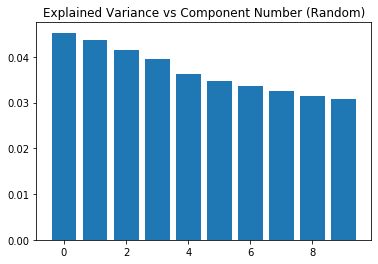

In [165]:
pca_r = PCA(n_components = 10)
pca_r.fit(np.random.rand(70,100))
plt.bar(range(10), pca_r.explained_variance_ratio_)
plt.title("Explained Variance vs Component Number (Random)")

In [136]:
# todo

In [142]:
with open('debiaswe-master/data/equalize_pairs.json') as f:
    pairs = json.loads(f.read())
pairs = list(map(lambda x: [x[0].lower(), x[1].lower()], pairs))

In [183]:
len(pairs)

52

In [121]:
with open('debiaswe-master/data/professions.json') as f:
    profs = json.loads(f.read())
proflist = list(filter(lambda x: x in mpol.wv.vocab, [p[0] for p in profs if abs(p[1]) < 0.6]))

In [139]:
with open('debiaswe-master/data/gender_specific_seed.json') as f:
    gender_specific = json.loads(f.read())

In [143]:
with open('debiaswe-master/data/gender_specific_full.json') as f:
    gender_specific_full = json.loads(f.read())

In [139]:
def getg(m, t, plot):
    matrix = []
    for a, b in pairs:
        if a not in m.wv.vocab or b not in m.wv.vocab:
            continue
        center = (m.wv.get_vector(a) + m.wv.get_vector(b))/2
        matrix.append(m.wv.get_vector(a) - center)
        matrix.append(m.wv.get_vector(b) - center)
    matrix = np.array(matrix)
    p = PCA(n_components = 10)
    p.fit(matrix)
    if plot:
        plt.bar(range(10), p.explained_variance_ratio_)
        plt.title("Explained Variance vs Component Number (" + t + ")")
    return p.components_[0]

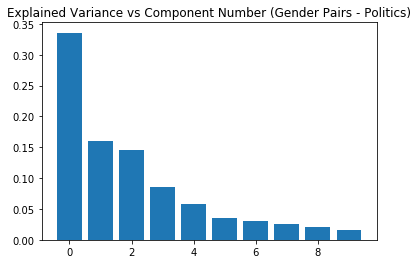

In [140]:
gpol = getg(mpol, "Gender Pairs - Politics", True)

## Regression for bias testing

In [140]:
def regress(g1, m1, g2, m2, wordlist):
    x = np.array([gproj(g1, m1, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    y = np.array([gproj(g2, m2, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope, p_value

In [141]:
regress(gpol, mpol, gpols, mpols, proflist)

(0.533629121432331, 1.5349588515623742e-57)

In [142]:
regress(gcomp, mcomp, gcomps, mcomps, proflist)

(-0.47288942755651714, 6.5938456670774195e-21)

In [143]:
regress(gtrav, mtrav, gtravs, mtravs, proflist)

(0.1988740624251196, 4.7826899611645153e-17)